# Exercise 1
#### Correia Ambre & Jeannes Théo

In [ ]:
!pip install matplotlib

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
COST_ADDING_NODE = 1
COST_REMOVING_NODE = 1
COST_ADDING_EDGE = 1
COST_REMOVING_EDGE = 1
COST_EDIT_EDGE = 1

In [27]:
G1 = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 1), (3, 1)])
G = nx.Graph([(1, 2), (2, 3), (3, 1)])

We start by creating graphs with networkx, then we create a variable-arity function to be able to display the graphs

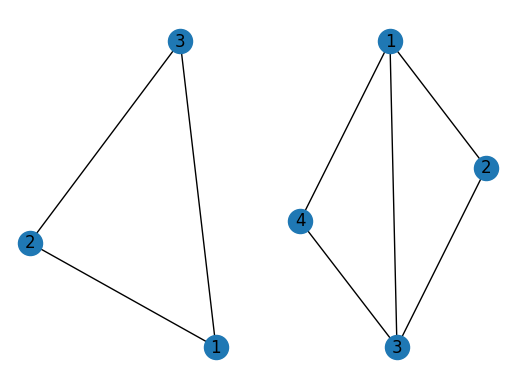

In [28]:
def plot_graphs(*args):
    for G in args:
        units = args.index(G) + 1
        dizaines = len(args)
        try:
            num = 100 + dizaines * 10 + units
            plt.subplot(num)
            nx.draw(G, with_labels='True')
        except Exception as e:
            print('Too much graphs')
    plt.show()


plot_graphs(G, G1)

Then, we create all the functions that allow us to check the isomorphism between two graphs. To achieve this, we obtain the adjacency matrices of the two graphs and check that the two matrices are equal up to a permutation

In [29]:
import itertools

def generate_permutation_matrices(size):
    identity_matrix = np.eye(size, dtype=int)
    permutation_matrices = []

    # Generate all permutations of rows of the identity matrix
    row_permutations = itertools.permutations(range(size))

    for permuted_indices in row_permutations:
        # Create a permutation matrix using the permuted row indices
        permutation_matrix = identity_matrix[list(permuted_indices)]
        permutation_matrices.append(permutation_matrix)

    return permutation_matrices


""" Takes two matrices and returns True if they are equal up to permutation of rows and columns.
The matrices are assumed to be square and of same shape"""


def equal_up_to_permutation(matrix1, matrix2):
    for i in generate_permutation_matrices(matrix1.shape[0]):
        if np.array_equal(np.matmul(i, matrix1), np.matmul(matrix2, i)):
            return True
    return False


def is_isomorphic(a, b):
    res = False
    if a.number_of_edges() == b.number_of_edges() and a.number_of_nodes() == b.number_of_nodes():
        adjacencies_a = nx.to_numpy_array(a)
        adjacencies_b = nx.to_numpy_array(b)
        if adjacencies_a.shape == adjacencies_b.shape and adjacencies_a.shape[0] == adjacencies_a.shape[
            1]:  # square matrix
            if equal_up_to_permutation(adjacencies_a, adjacencies_b):
                res = True
    return res

We can then construct a supergraph that contains all possible evolutions leading from the initial graph to the target graph. It is sufficient to assign weights to each edge, representing the modification between two graphs, and then apply Dijkstra's algorithm to find the optimal path, i.e., the distance between two graphs

In [30]:
"""
Algorithm to naively calculate the distance between two graphs by deleting and recreating all edges
"""
def compute_naive_distance(a, b):
    diff_node = a.number_of_nodes() - b.number_of_nodes()
    cost = (a.number_of_edges() * COST_REMOVING_EDGE +
            b.number_of_edges() * COST_ADDING_EDGE)
    if diff_node > 0:
        cost_nodes = diff_node * COST_REMOVING_NODE
    else:
        cost_nodes = -(diff_node * COST_ADDING_NODE)
    return cost + cost_nodes, cost_nodes


"""
Check if an edge has a common point with the provided list
"""


def no_commun_point(edge, points_edges):
    for i in list(edge):
        if i in points_edges:
            return False
    return True


"""
Build a dictionary that associates the connections to be edited with the possible edges in the target grap
"""


def generate_edges_to_edit(start_edges, edges_to_keep, edges_to_remove, edges_goal, ):
    edges_to_edit = [i for i in start_edges if i not in edges_to_keep and i not in edges_to_remove]
    edges_to_edit_with_options = {}
    for i in edges_to_edit:
        options = []
        for j in edges_goal:
            if j not in edges_to_keep and (j[0] == i[0] or j[1] == i[
                1]):  #We check that the connection is not already in the existing edges
                    #and that it has at least one common point with the points.
                options.append(j)
        if options:
            edges_to_edit_with_options[i] = options
    return edges_to_edit_with_options


def edit_edge(tmp, edge, new_edge):
    tmp.remove_edge(*edge)
    tmp.add_edge(*new_edge)

def compute_path(b, gsuper, max_distance, start):
    try:
        plot_graphs(gsuper)
        return nx.single_source_dijkstra(gsuper, start, b, cutoff=max_distance)[0]
    except nx.NetworkXNoPath:
        print('No path found')
        return max_distance


def add_to_supergraph(graph, gsuper, tmp, goal, weight):
    is_finished = is_isomorphic(tmp, goal)
    if is_finished:
        gsuper.add_edge(graph, goal, weight=weight)
    else:
        gsuper.add_edge(graph, tmp, weight=weight)
    return is_finished


In [31]:
def compute_distance(a, b):
    if is_isomorphic(a, b):
        return 0
    else:
        max_distance, add_nodes_distances = compute_naive_distance(a, b)
        gsuper = nx.Graph()
        start = a.copy()
        gsuper.add_node(start)
        i = 0
        list_nodes = [start]
        nodes_b = list(b.nodes())
        edges_b = list(b.edges())
        nb_nodes_b = len(nodes_b)
        nb_edges_b = len(edges_b)
        while i < max_distance:  #As long as the cost of the options in the graph is lower than the naive cost.
            new_list_nodes = []
            plot_graphs(*list_nodes)
            for graph in list_nodes:
                tmp = graph.copy()

                if graph.number_of_nodes() < nb_nodes_b:  #Add nodes if there are not enough
                    tmp.add_node(graph.number_of_nodes() + 1)
                    if add_to_supergraph(graph, gsuper, tmp, b, COST_ADDING_NODE):
                        return compute_path(b, gsuper, max_distance, start)
                    new_list_nodes.append(tmp)
                elif graph.number_of_nodes() > nb_nodes_b:  # if there are too many nodes, we remove them
                    for nb_node in list(graph.nodes)[nb_nodes_b:]:
                        tmp = graph.copy()
                        if not any(graph.neighbors(nb_node)):  #only if the node is not connected to any other node
                            tmp.remove_node(nb_node)
                            if add_to_supergraph(graph, gsuper, tmp, b, COST_REMOVING_NODE):
                                return compute_path(b, gsuper, max_distance, start)
                            new_list_nodes.append(tmp)

                # If nodes matches, we check the edges
                edges_to_keep = [i for i in graph.edges if i in edges_b]
                interesting_points = set(np.array([i for i in graph.edges if i in edges_b]).ravel())
                edges_to_remove = [i for i in graph.edges if no_commun_point(i, interesting_points)]

                if graph.number_of_edges() > nb_edges_b:  # Remove edges if there are too many
                    if not edges_to_remove: # If there are no edges without common points, we remove one among those that have only one common point
                        edges_to_remove += [i for i in graph.edges if i not in edges_to_keep]
                    tmp = graph.copy()
                    tmp.remove_edge(*edges_to_remove[0])  # We remove the first edge that has no common points
                    if add_to_supergraph(graph, gsuper, tmp, b, COST_REMOVING_EDGE):
                        return compute_path(b, gsuper, max_distance, start)
                    new_list_nodes.append(tmp)
                else:  # 2 cases : either we add edges, or we edit them
                    if graph.number_of_edges() < nb_edges_b:
                        points_allowed = set(np.array(graph.nodes).ravel())
                        edges_to_add = [i for i in edges_b if # We add edges that are not already in the graph, only if the points are in the graph
                                        i not in graph.edges and (i[0] in points_allowed and i[1] in points_allowed)]
                        for edge in edges_to_add:
                            tmp = graph.copy()
                            tmp.add_edge(*edge)
                            if add_to_supergraph(graph, gsuper, tmp, b, COST_ADDING_EDGE):
                                return compute_path(b, gsuper, max_distance, start)
                            new_list_nodes.append(tmp)
                    edges_to_edit = generate_edges_to_edit(graph.edges, edges_to_keep, edges_to_remove, edges_b)
                    for edge, options in edges_to_edit.items():
                        for option in options:
                            tmp = graph.copy()
                            edit_edge(tmp, edge, option)
                            if add_to_supergraph(graph, gsuper, tmp, b, COST_EDIT_EDGE):
                                return compute_path(b, gsuper, max_distance, start)
                            new_list_nodes.append(tmp)
            list_nodes = new_list_nodes
            i += min(COST_ADDING_NODE, COST_REMOVING_NODE, COST_REMOVING_EDGE, COST_ADDING_EDGE, COST_EDIT_EDGE)
        return compute_path(b, gsuper, max_distance, start)

We then try the algorithm on several graphs. It find the same path if we switch parameters, which is logical since all costs are 1. Each time, we display the graphs that are leafs of the supergraph, i.e. the graphs that should be closest to the target graph. The last graph displayed is the supergraph, which contains all the possible evolutions of the initial graph that have been explored.

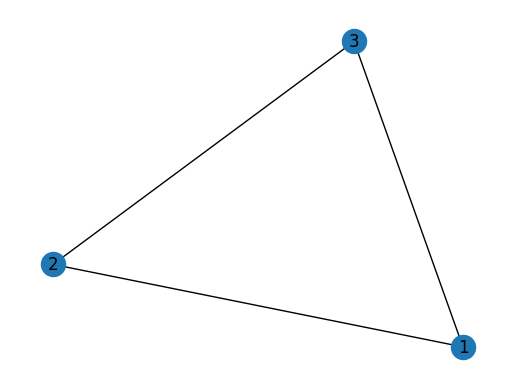

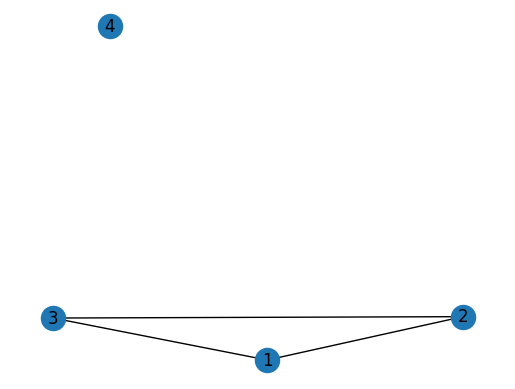

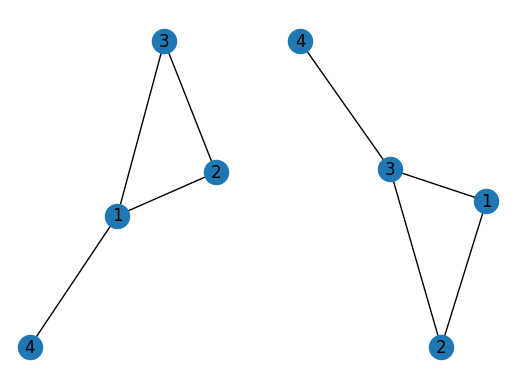

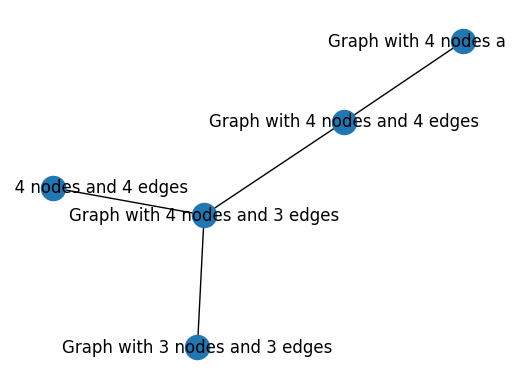

Minimal edit cost :  3


In [32]:
print('Minimal edit cost : ',compute_distance(G, G1))

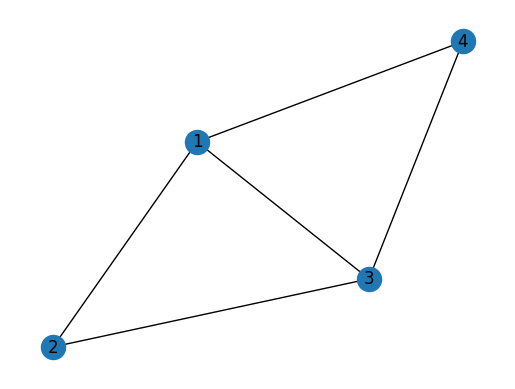

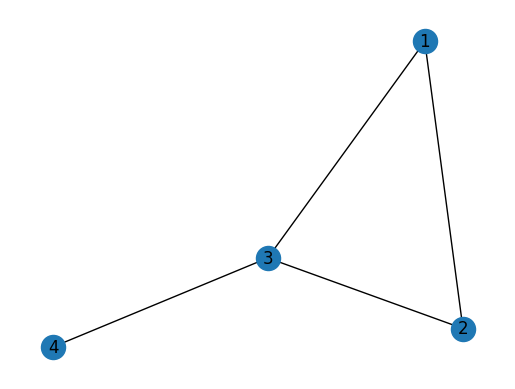

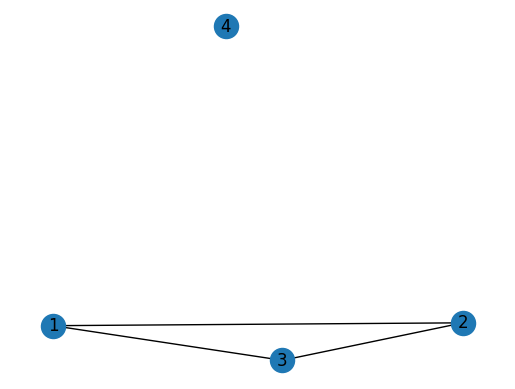

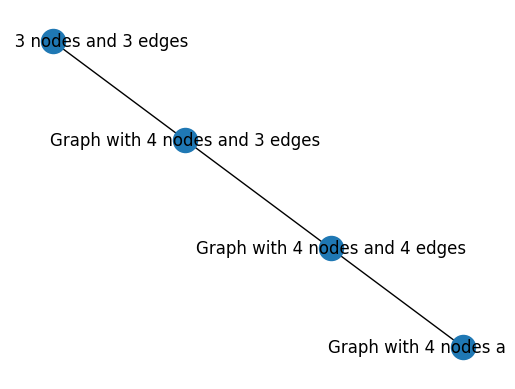

Minimal edit cost :  3


In [33]:
print('Minimal edit cost : ',compute_distance(G1, G))

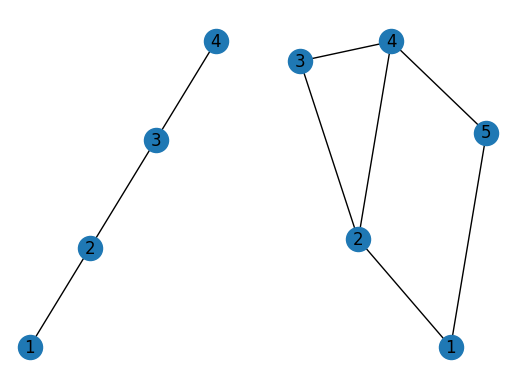

In [34]:
G = nx.Graph([(1,2),(2,3),(3,4)])
G1 = nx.Graph([(1,2),(2,3),(3,4),(4,5),(4,2),(5,1)])
plot_graphs(G,G1)

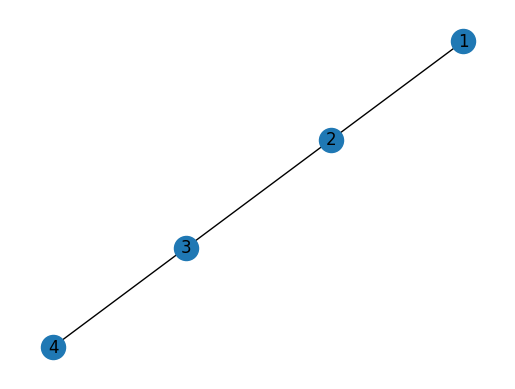

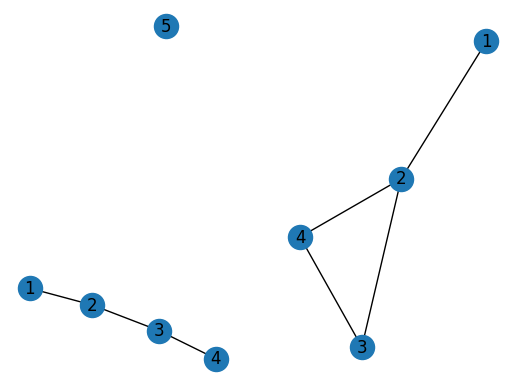

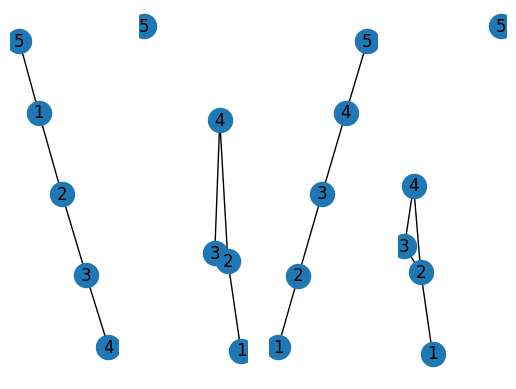

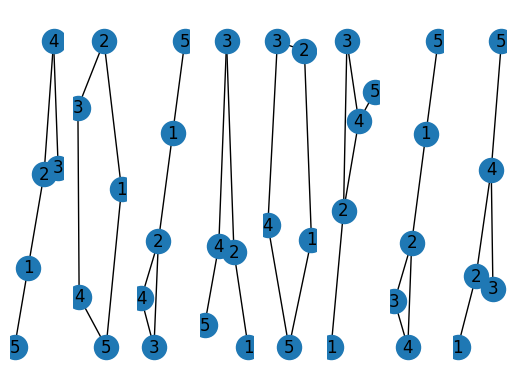

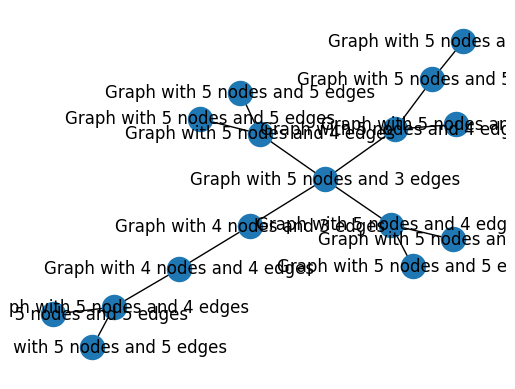

Minimal edit cost :  4


In [35]:
print('Minimal edit cost : ',compute_distance(G, G1))

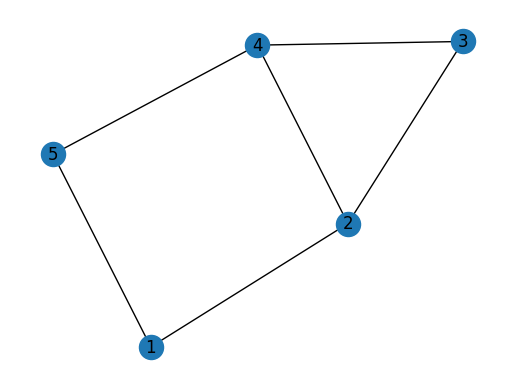

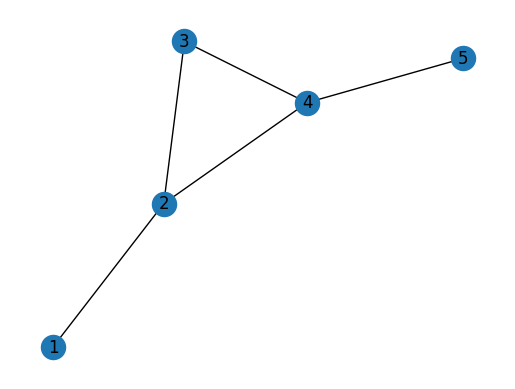

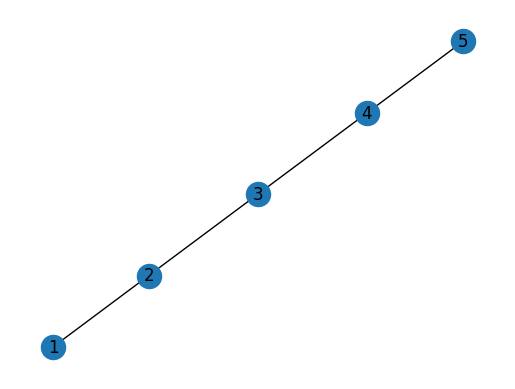

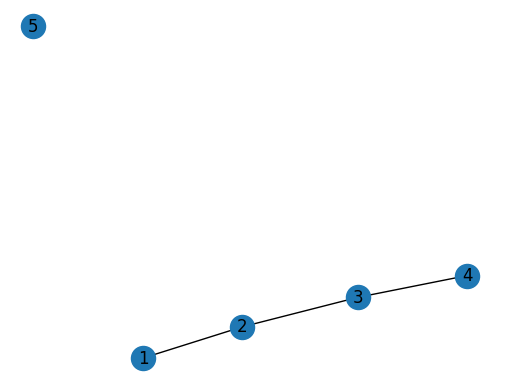

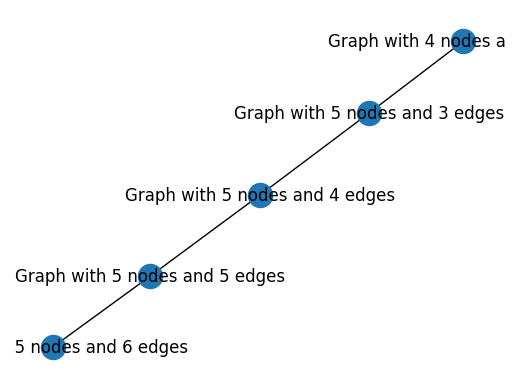

Minimal edit cost :  4


In [36]:
print('Minimal edit cost : ',compute_distance(G1, G))